In [1]:
import re
import time
import datazimmer as dz

from functools import reduce
from pathlib import Path
from zipfile import ZipFile

import pandas as pd
import geopandas as gpd
import fiona

from aswan import get_soup
from bs4 import BeautifulSoup
from selenium.webdriver import Chrome, Firefox
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException

In [2]:
def rename_map(ser, dic):
    return reduce(lambda s, kv: s.str.replace(*kv, regex=False), dic.items(), ser)


In [3]:
soup = get_soup("https://efop180.antsz.hu/csapviz-olomtartalom-kockazati-terkep.html")

In [21]:
driver = Chrome()

In [22]:
dl_folder = Path.home() / "Downloads"

In [23]:
found_already = [p.name.split(".")[0] for p in dl_folder.glob("*.kmz")]

In [24]:
def _get(xpath, tries = 5):
    for _ in range(tries):
        time.sleep(1)
        try:
            return driver.find_element(By.XPATH, xpath)
        except NoSuchElementException:
            continue

In [25]:
for area in soup.find_all("area", href=re.compile("maps/")):
    if area["title"] in found_already:
        continue
    time.sleep(3)

    driver.get(area["href"])
    time.sleep(1)
    elem = _get("/html/body/div[1]/div[3]/div[2]/div/div/div[1]/div[5]/div")
    elem.click()
    dl_elem = _get("/html/body/div[3]/div/div/span[7]/div[2]/div")
    dl_elem.click()
    ok_elem = _get("/html/body/div[3]/div/div[2]/div[3]/div[2]/span")
    ok_elem.click()
    time.sleep(15)

In [26]:
from geopandas.io.file import _import_fiona

_import_fiona()

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [27]:
ext_file = Path("doc.kml")

In [28]:
dfs = []
for filename in dl_folder.glob("*.kmz"):
    with ZipFile(filename, "r") as zfp:
        zfp.extractall(".")
    gxml = BeautifulSoup(ext_file.read_bytes(), "xml")
    for coords in gxml.find_all("coordinates"):
        if len(next(coords.children).strip().split()) < 2:
            coords.parent.decompose()
    ext_file.write_bytes(gxml.encode("utf-8"))
    try:
        dfs.append(gpd.read_file(ext_file, driver='KML'))
    except:
        print(filename)

In [29]:
len(dfs)

20

In [30]:
trans = {
    "kockázat": "risk",
    "alacsony": "low",
    "nagyon": "very",
    "magas": "high",
    "közepes": "medium",
    "nem besorolható": "nonclassified",
}

In [31]:
df = (
    pd.concat(dfs)
    .assign(
        risk=lambda df: df["Description"]
        .str.extract("zat: (.*)")
        .loc[:, 0]
        .pipe(rename_map, trans)
    )
    .drop(["Description", "Name"], axis=1)
)

In [32]:
df.loc[df["geometry"].geom_type != "GeometryCollection", :].to_file(
    dz.get_raw_data_path("lead-hungary.shp.zip")
)

<AxesSubplot:>

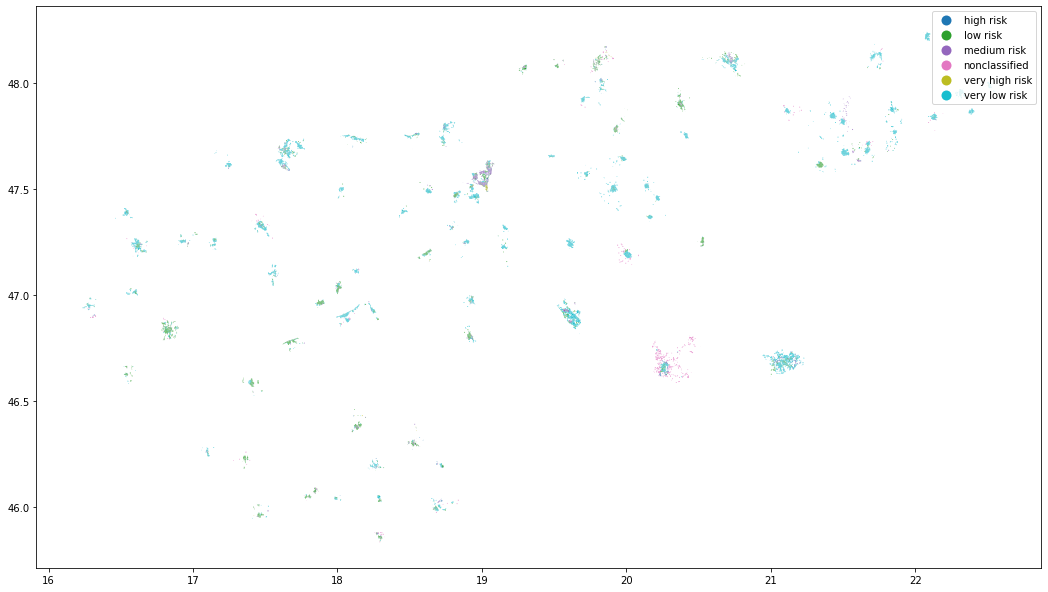

In [33]:
df.plot(figsize=(18, 16), column="risk", legend=True)

In [37]:
df["risk"].value_counts()

very low risk     15024
low risk           6464
medium risk        2208
high risk           777
nonclassified       556
very high risk      374
Name: risk, dtype: int64

In [36]:
df["geometry"].geom_type.value_counts()

Polygon               21475
MultiPolygon           3852
GeometryCollection       76
dtype: int64

In [38]:
ext_file.unlink()